# Laboratorium 2
Kamil Patan

## Wstęp
Skrypt został stworzony dla podstawowej wersji algorytmu Gillespiego, służącej do modelowania stochastycznej dynamiki czterech cząsteczek biologicznych: P53, MDM2 (cytoplazmatycznego i jądrowego) oraz PTEN. Trzon metody (losowanie czasu i wyboru reakcji) został zaimplementowany ręcznie, bez użycia zewnętrznych bibliotek matematycznych.

## Opis
Zastosowany wariant: Gillespie – algorytm stochastyczny.
Każdy scenariusz odpowiada innym warunkom biologicznym:

    Basic – brak siRNA, aktywny PTEN, brak uszkodzenia DNA

    Damaged DNA – brak siRNA, aktywny PTEN, obecne uszkodzenie DNA

    Tumor – brak siRNA, wyłączony PTEN, brak uszkodzenia DNA

    Therapy – obecność siRNA, aktywny PTEN, brak uszkodzenia DNA

Symulacja trwa 48 godzin. Własny generator liczb pseudolosowych oraz logarytm naturalny zostały zaimplementowane bez użycia bibliotek (random, math, numpy itp.).

Wejście/Wyjście:
Brak pliku wejściowego – dane oraz parametry są zapisane bezpośrednio w kodzie.
Wyniki zapisywane są w katalogu plots_lab2/ w formacie PNG:

    16 wykresów indywidualnych – osobny plik dla każdej zmiennej i scenariusza (np. Tumor_PTEN.png)

    4 wykresy zbiorcze – wszystkie zmienne na jednym wykresie dla każdego scenariusza (np. Therapy.png)

## Skrypt

In [2]:
"""
  Algorytmu Gillespiego

Scenariusze:
  A) podstawowy  (siRNA=False, PTEN_off=False, no_DNA_damage=True)
  B) uszkodzenie (siRNA=False, PTEN_off=False, no_DNA_damage=False)
  C) nowotwór    (siRNA=False, PTEN_off=True, no_DNA_damage=False)
  D) terapia     (siRNA=True, PTEN_off=False, no_DNA_damage=False)

Wynik:
  - Katalog "plots_lab2/"
  - Pliki PNG:
    - 16 indywidualnych: <scenariusz>_<zmienna>.png (P53, MDM2_cyt, MDM2_nuc, PTEN dla każdego scenariusza)
    - 4 połączone: <scenariusz>.png (wszystkie zmienne w jednym wykresie dla każdego scenariusza)
"""
import matplotlib.pyplot as plt
import os

# Parametry modelu
# Szybkości produkcji
p1 = 8.8    # produkcja P53
p2 = 440    # produkcja MDM2
p3 = 100    # produkcja PTEN
# Szybkości degradacji
d1 = 1.375e-14  # degradacja P53
d2 = 1.375e-4   # degradacja MDM2
d3 = 3e-5   # degradacja PTEN
# Stałe oddziaływań
k1 = 1.925e-4
k2 = 1e5
k3 = 1.5e5

# Czynniki warunkowe
siRNA_factor = 0.02
PTEN_off_factor = 0.0
DNA_damage_factor = 0.1

# Generator liczb losowych
import time
random_seed = int(time.time()) % (2**31)

def simple_random():
    global random_seed
    random_seed = (random_seed * 1103515245 + 12345) % (2**31)
    return random_seed / (2**31)

# Przybliżenie logarytmu naturalnego
def approx_ln(x):
    if x <= 0:
        return 0
    n = 20
    x = (x - 1) / (x + 1)
    result = 0
    for i in range(n):
        term = (2 * x**(2*i + 1)) / (2*i + 1)
        result += term
    return result

# Trzon algorytmu Gillespie
def gillespie_step(state, siRNA, PTEN_off, DNA_damage):
    p53, mdmcyto, mdmn, pten = state

    # Obliczanie propensji dla każdej reakcji elementarnej
    propensities = [
        p1, # produkcja p53
        d1 * p53 * mdmn**2, # degradacja p53
        p2 * (siRNA_factor if siRNA else 1) * (p53**4) / ((p53**4) + (k2**4)),  # produkcja MDM2_cyt
        k1 * (k3**2) / ((k3**2) + (pten**2)) * mdmcyto, # MDM2_cyt do MDM2_nuc
        d2 * (DNA_damage_factor if DNA_damage else 1) * mdmcyto,    # degradacja MDM2_cyt
        k1 * (k3**2) / ((k3**2) + (pten**2)) * mdmcyto, # produkcja MDM2_nuc
        d2 * (DNA_damage_factor if DNA_damage else 1) * mdmn,   # degradacja MDM2_nuc
        (p3 if not PTEN_off else p3 * PTEN_off_factor) * (p53**4) / ((p53**4) + (k2**4)),   # produkcja PTEN
        d3 * pten
    ]
 
    # Wektor zmian stanu dla każdej reakcji
    changes = [
        [1, 0, 0, 0],    # p53 produkcja
        [-1, 0, 0, 0],   # p53 degradacja
        [0, 1, 0, 0],    # MDM2_cyt produkcja
        [0, -1, 1, 0],   # MDM2_cyt -> MDM2_nuc
        [0, -1, 0, 0],   # MDM2_cyt degradacja
        [0, 0, 1, 0],    # MDM2_nuc produkcja
        [0, 0, -1, 0],   # MDM2_nuc degradacja
        [0, 0, 0, 1],    # PTEN produkcja
        [0, 0, 0, -1]    # PTEN degradacja
    ]

    # Suma wszystkich propensji
    total = sum(propensities)
    if total == 0:
        return state, float('inf')

    # Losowanie dwóch liczb
    r1 = simple_random()
    r2 = simple_random()

    # Obliczenie czasu do następnej reakcji (tau)
    tau = -approx_ln(r1) / total

    # Wybór reakcji na podstawie r2 i skumulowanej sumy propensji
    limit = r2 * total
    cumulative = 0
    for i, a in enumerate(propensities):
        cumulative += a
        if cumulative > limit:
            selected = i
            break

    # Aktualizacja stanu na podstawie wybranej reakcji
    new_state = [max(0, state[j] + changes[selected][j]) for j in range(4)]
    return new_state, tau

# Uruchomienie symulacji
def simulate(name, siRNA, PTEN_off, DNA_damage):
    time_min = 0
    max_time = 48 * 60
    state = [26854, 11173, 17245, 154378]       # Stan początkowy: liczba cząsteczek [p53, MDM2_cyt, MDM2_nuc, PTEN]
    times = [time_min]
    data = [state.copy()]

    # Główna pętla symulacyjna (do momentu osiągnięcia max_time)
    while time_min < max_time:
        # Wykonanie jednego kroku algorytmu Gillespiego
        state, dt = gillespie_step(state, siRNA, PTEN_off, DNA_damage)
        # Jeśli nie ma dalszych reakcji – zakończ symulację
        if dt == float('inf'):
            break
        time_min += dt
        times.append(time_min)
        data.append(state.copy())

    p53_vals, mdmcyto_vals, mdmn_vals, pten_vals = zip(*data)
    variables = {
        "P53": p53_vals,
        "MDM2_cyt": mdmcyto_vals,
        "MDM2_nuc": mdmn_vals,
        "PTEN": pten_vals
    }

    folder = "plots_lab2"
    os.makedirs(folder, exist_ok=True)

    # 16 indywidualnych wykresów (po jednym dla każdej zmiennej w każdym scenariuszu)
    for var_name, values in variables.items():
        plt.figure()
        plt.step(times, values, label=var_name)
        plt.xlabel("Czas [min]")
        plt.ylabel("Liczba cząsteczek")
        plt.title(f"{var_name} - {name}")
        plt.legend()
        plt.grid(True)
        filename = os.path.join(folder, f"{name}_{var_name}.png")
        plt.savefig(filename)
        plt.close()

    # 4 połączone wykresy (wszystkie zmienne w jednym wykresie dla każdego scenariusza)
    plt.figure()
    for var_name, values in variables.items():
        plt.step(times, values, label=var_name)
    plt.xlabel("Czas [min]")
    plt.ylabel("Liczba cząsteczek")
    plt.title(f"Symulacja Gillespie - {name}")
    plt.legend()
    plt.grid(True)
    filename = os.path.join(folder, f"{name}.png")
    plt.savefig(filename)
    plt.close()

# Główna funkcja
def main():
    scenariusze = {
        "Basic": (False, False, True),
        "Damaged_DNA": (False, False, False),
        "Tumor": (False, True, False),
        "Therapy": (True, False, False),
    }
    for name, (sirna, pten_off, damage) in scenariusze.items():
        simulate(name, sirna, pten_off, damage)

if __name__ == "__main__":
    main()


## Wykresy
## Scenariusz A
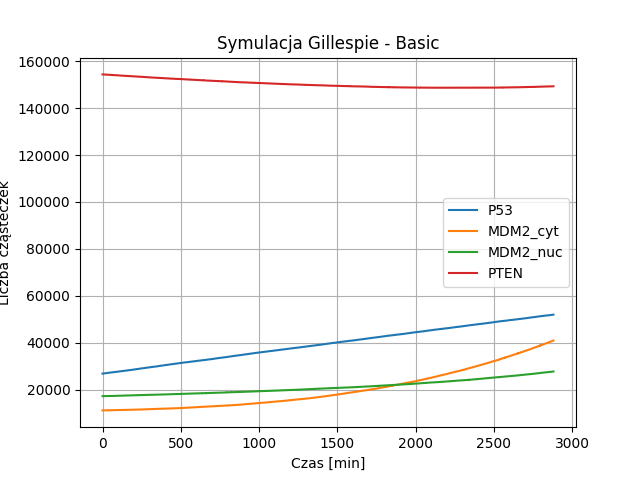
## MDM2_cyt
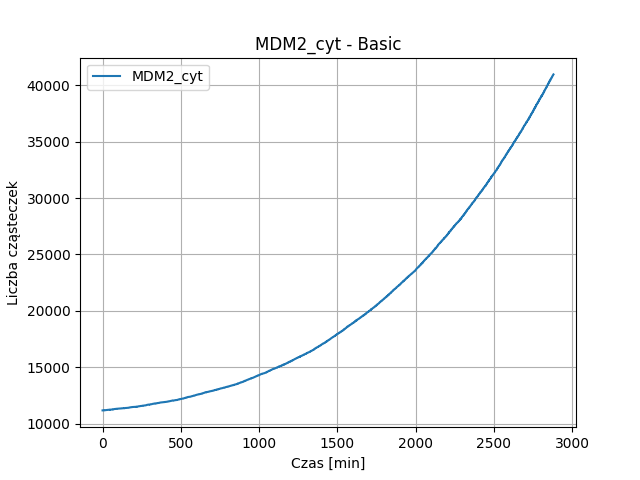
## MDM2_nuc
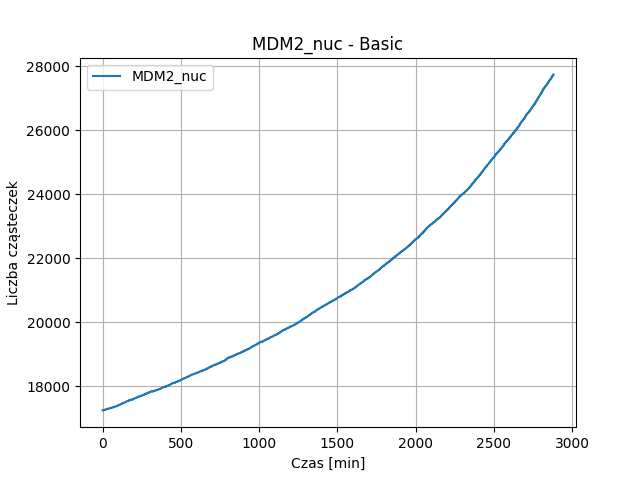
## P53
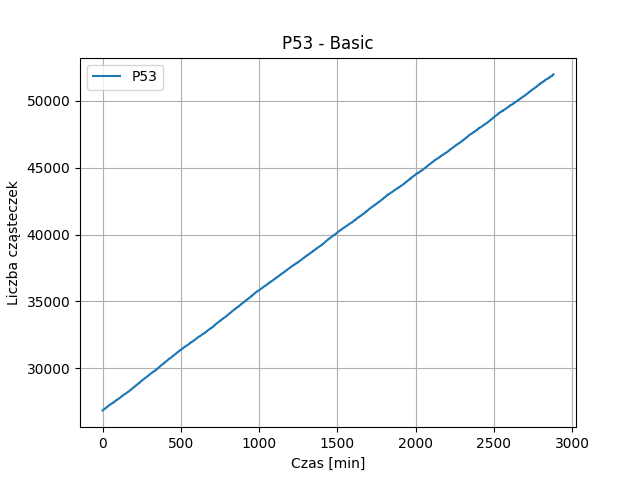
## PTEN
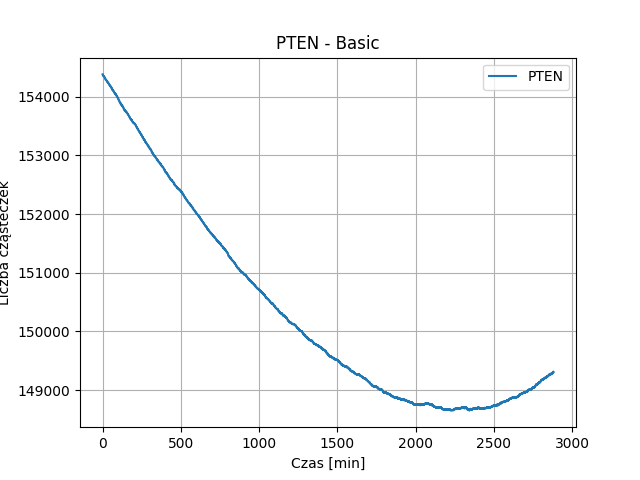

## Scenariusz B
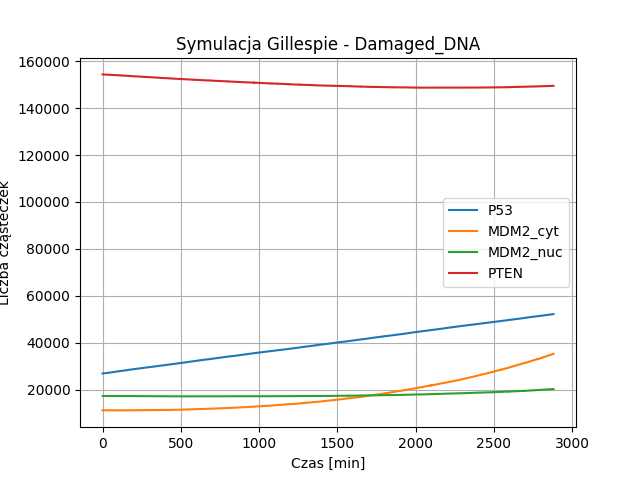
## MDM2_cyt
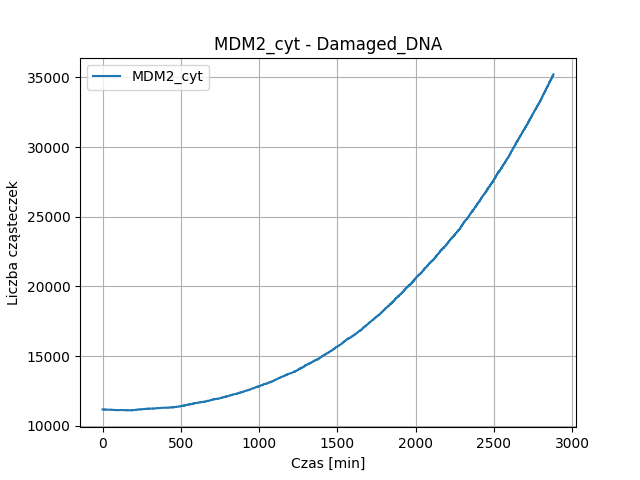
## MDM2_nuc
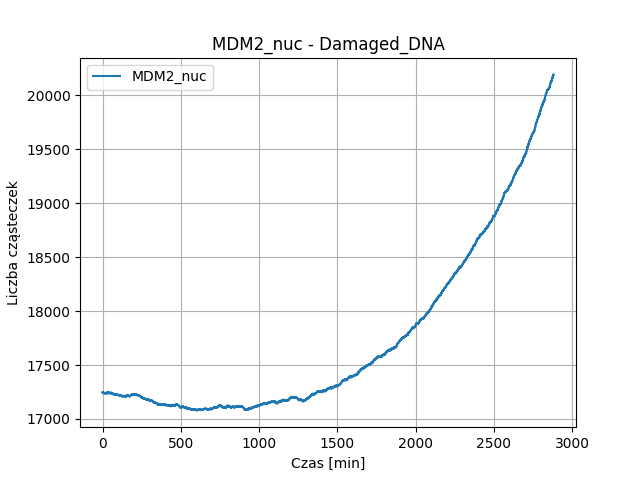
## P53
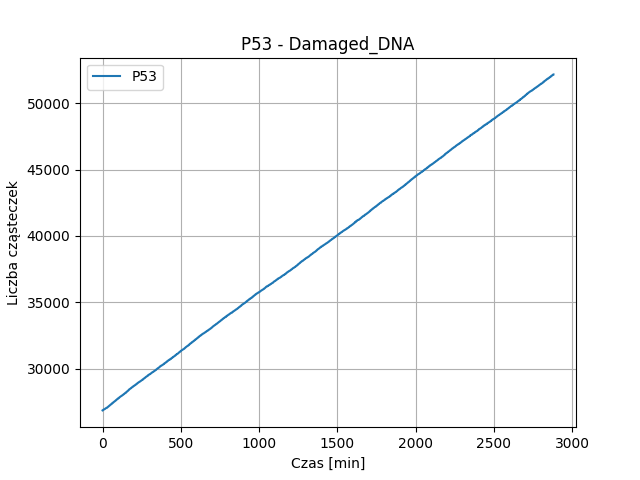
## PTEN
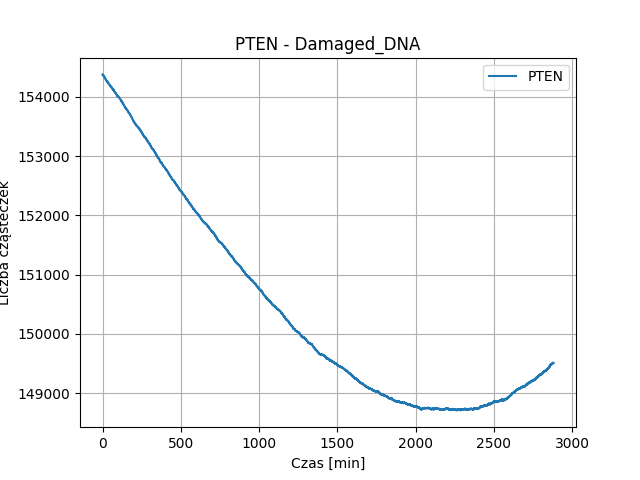

## Scenariusz C
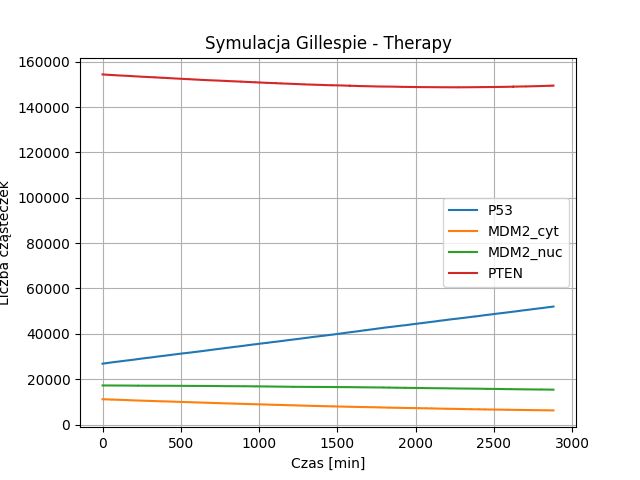
## MDM2_cyt
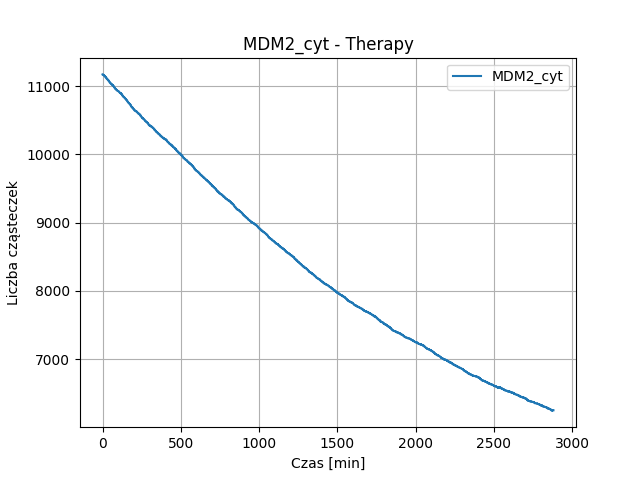
## MDM2_nuc
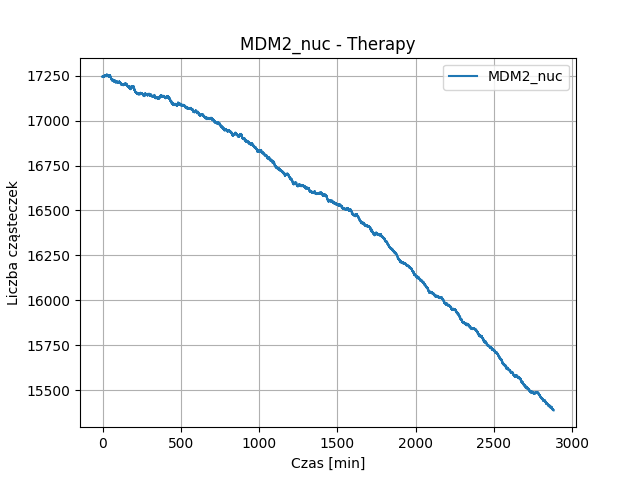
## P53
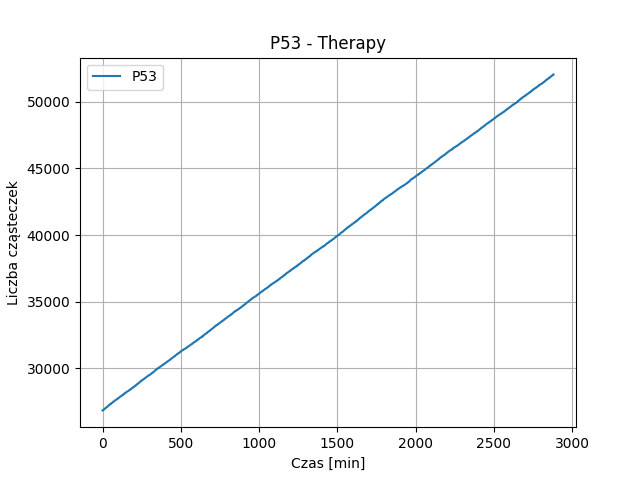
## PTEN
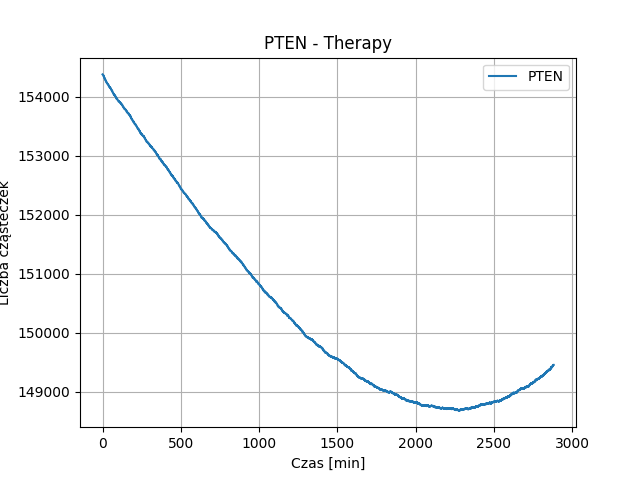

## Scenariusz D
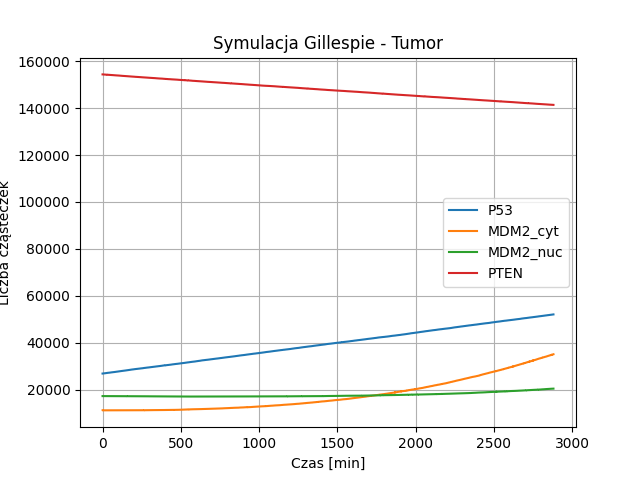
## MDM2_cyt
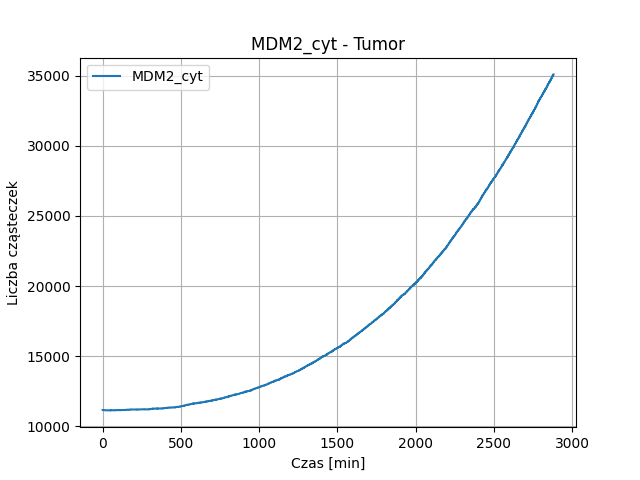
## MDM2_nuc
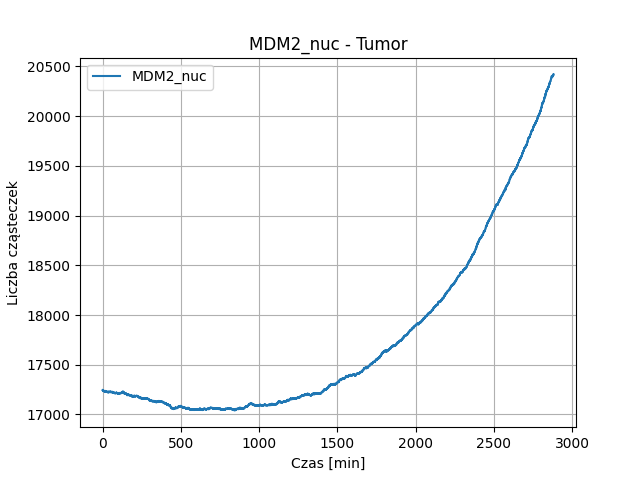
## P53
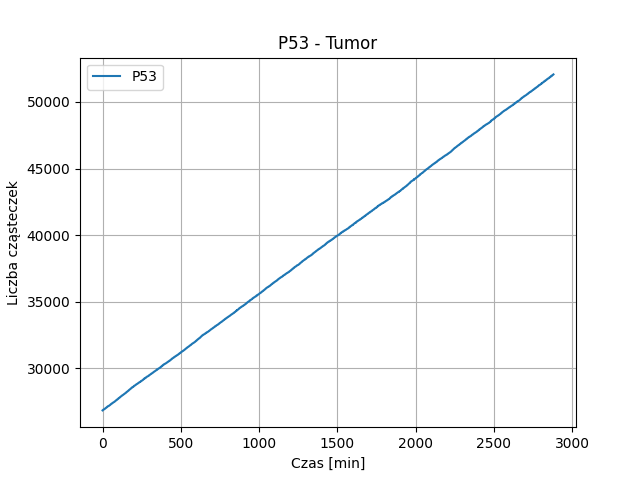
## PTEN
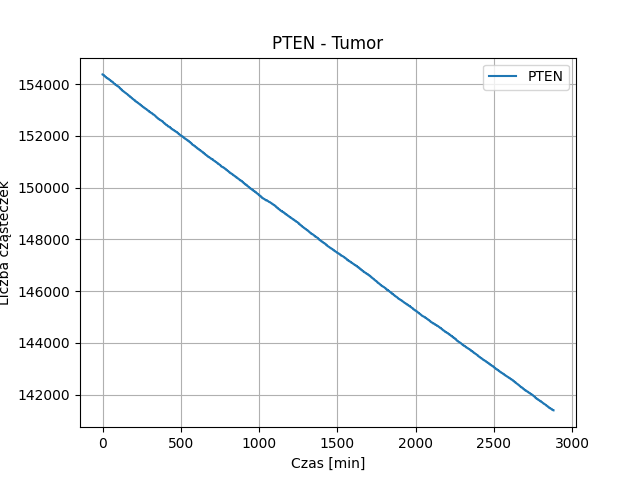
